# Árboles LLRB

In [1]:
using LLRBTrees, LLRBVisualize

## Árboles

El árbol **LLRB** (*left-leaning red-black* o rojo-negro inclinado a la izquierda) es una **estructura de datos**,
es decir, un objeto que guarda datos y soporta cietas operaciones.

Esta estructura salva datos en **nodos**, que son pares de claves (**keys**) y valores (**values**) y que tienen vínculos a otros nodos. Como cualquier árbol, debe tener un nodo raíz (**root**), que no tiene ningún padre (osea no está vinculado a ningún otro nodo), desde el cuál se puede acceder a todos los otros nodos.

Además, este tipo de árbol es **binario**. Así que cada nodo puede tener dos hijos como máximo. Si no tiene hijos en alguna de sus vacantes, a esta vacante la llamaremos hoja (**leaf**).

El orden de los nodos se hace mediante las claves (keys). La convención es que un hijo izquierdo siempre tiene una clave menor a la de su padre y uno derecho, mayor.

## Árbol básico

Para visualizar esto armemos un árbol básico.

El objeto árbol lo podemos iniciar especificando los tipos de objeto de las claves y valores (las claves deben de tener un orden total):

In [2]:
arbol = LLRBTree{Int, ASCIIString}()

LLRBTrees.LLRBTree{Int64,ASCIIString}


O podemos simplemente indicar los valores de la raíz y julia adivinará los tipos

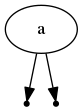

In [2]:
arbol = LLRBTree(1,"a")
display(arbol)

In [3]:
typeof(arbol)

LLRBTrees.LLRBTree{Int64,ASCIIString}

Para añadir un hijo adoptamos el método de Base `push!` y le podemos dar los valores

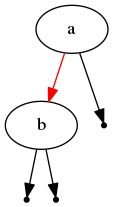

In [4]:
push!(arbol, 0, "b")
display(arbol)

O un nodo

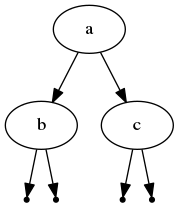

In [9]:
nodo = TreeNode(2, "c")
push!(arbol, nodo)
display(arbol)

## Utilidad

La conveniencia de los árboles binarios de búsqueda (**binary-search trees** o **BST's**) es la velocidad que ofrecen en la búsqueda de una clave.

Para mantener un arreglo de objetos en la memoria se guarda normalmente uno de sus elementos en la memoria y a los demás se les accede por medio de vínculos entre ellos.

Si se tuviera una cadena lineal de objetos (e.d. un arreglo no ordenado)

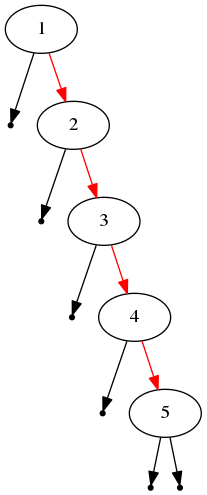

In [5]:
unsorted = LLRBTree(1,1)

nodoactual = unsorted.root
for i in 2:5
    nodoactual.right = TreeNode(i,i)
    nodoactual = nodoactual.right
end

unsorted|>display

Se necesitarían tantos pasos para llegar al último elemento como elementos tenga el árbol.

In [3]:
@time unsorted[5]

  0.029779 seconds (13.13 k allocations: 538.417 KB)


Nullable(5)

En cambio, en un arbol binario de búsqueda (**BST**) las claves tiene un orden. Entonces, se hace una comparación para ver si la clave buscada es mayor o menor.

Así que en cada comparación se salta uno en promedio la mitad del arbol debajo del nodo.

Por lo que cada búsqueda, inserción o extracción toma aproximadamte el logaritmo base 2 del número de elementos del árbol en pasos.

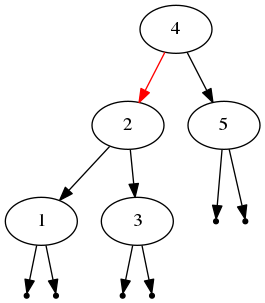

In [16]:
arbol = LLRBTree(1,1) 
for i in 2:5
    push!(arbol, i,i)
end
display(arbol)

In [17]:
@time arbol[5]

  0.000003 seconds (5 allocations: 192 bytes)


Nullable(5)

Hay que tomar en cuenta que esta comparación en tiempos no es tan justa pues el `getindex()` de los arboles pregunta por el elemento izquierdo primero y luego va al derecho.

## Árboles rojo-negros

Ahora, algo que no es tan fácil es mantener el árbol más o menos balanceado.

**Balanceado** quiere decir que cualquier camino de la raíz a una hoja tenga el mismo número de pasos.

Para mantener a los árboles balanceados se han diseñado muchos tipos de árboles auto-balanceados (*self-balancing trees*). Osea que, a medida que se le añaden o quitan elementos, se ejecutan otras operaciones que aseguran una especie de balance.


El método que usamos nosotros es una variación de los árboles rojo-negros (**red-black trees** o **RBT**) que fueron introducidos por **Guibas** y **Robert Sedgewick** hace 30 años, diseñada por el mismo autor **Sedgewick**.

Los RBT's son una representación binaria de árboles con nodos que pueden tener hasta 4 hijos (**2-3-4 Trees**). En nuestra implementación representamos a un vínculo rojo con el padre como un nodo rojo (al que se la añade "_r" en nuestra representación ASCII) y los nodos vinculados son parte de un gran nodo.

![2-3 vs BST](./23andBSTs.png)
***Fuente: Sedgewick, R. (2008, April). Left-leaning red-black trees. In Dagstuhl Workshop on Data Structures (p. 19).***

Estos nodos grandes se utilizan para no tener que aumentar o disminuir la altura de solo una rama del árbol cuando se añade o sustrae un nodo. Esto se traduce a mantener las siguientes invariantes

Por eso, en nuestra implementación, siempre habrá el **mismo número** de saltos hacia **nodos negros**, cuando se va de la raíz a cualquier hoja y **nunca habrá dos nodos rojos consecutivos**.

En esta implementación se siguen tres principios básicos que hacen que el código sea mas elegante:

* Implementación recursiva
* Solo puede haber 3-nodos y el vínculo solo puede estar a la izquierda (por eso es **left-leaning**). Con esto hay una correspondencia uno a uno con los arboles 2-3
* Se hacen modificaciones al regresar de la recursión. Por ej. se permiten 4-nodos que en el regreso se convierten en tres dos 2-nodos y el nodo del medio pasa su vínculo al padre

## Operaciones elementales

Para manipular los objetos en nuestro código sin violar el balance de negros (que siempre haya el mismo numero de nodos negros llendo de la raíz a una hoja), usamos tres operaciones que mantienen ese balance. Las rotaciones izquierda y derecha y el voltear colores.

### Rotaciones

Las rotaciones pueden usarse para convertir un 3-nodo que se inclina a la izquierda (derecha) en uno que se inclina al lado opuesto. 

En un rotación derecha podemos tener el siguiente caso

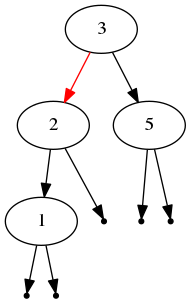

In [20]:
arbol = LLRBTree(3,3)
arbol.root.left = TreeNode(2,2)
arbol.root.left.left = TreeNode(1,1)
arbol.root.left.left.isRed = false
arbol.root.right = TreeNode(5,5)
arbol.root.right.isRed = false
display(arbol)

``` julia
function rotateright{K,V}(node::TreeNode{K,V})

    if isleftleaf(node)
        error("The left part of the given node must be a node")
    end
    son=node.left

    if !isrightleaf(son)
        node.left=son.right
    else
        node.left=TreeNode{K,V}()
    end
    son.right=node

    son.isRed=node.isRed
    node.isRed=true
    return son
end
```

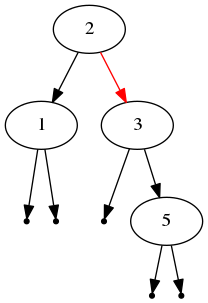

In [21]:
arbol.root=LLRBTrees.rotateright(arbol.root)
display(arbol)

Y en la rotación izquierda

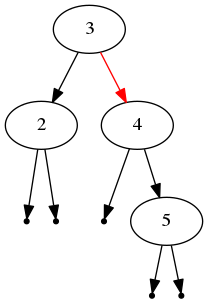

In [29]:
arbol = LLRBTree(3,3)
arbol.root.left = TreeNode(2,2)
arbol.root.left.isRed = false
arbol.root.right = TreeNode(4,4)
arbol.root.right.right = TreeNode(5,5)
arbol.root.right.right.isRed =false

display(arbol)

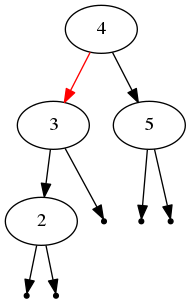

In [30]:
#Con un codigo análogo logramos esto
arbol.root=LLRBTrees.rotateleft(arbol.root)
display(arbol)

### Volteado de color

Para eliminar un 4-nodo podemos invertir el color de los un nodo y sus hijos.
Esto mantiene el balance pues pasa el vinculo al nodo padre.

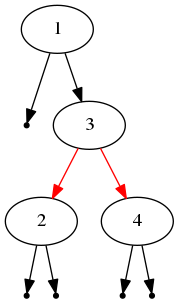

In [7]:
arbol = LLRBTree(3,3)
arbol.root.left = TreeNode(2,2)
arbol.root.right = TreeNode(4,4)
old = arbol.root
arbol.root = TreeNode(1,1)
arbol.root.right = old
display(arbol)

```julia
function flipcolor!{K,V}(node::TreeNode{K,V})

    node.isRed = !node.isRed
    if !isleftleaf(node)
        node.left.isRed = !node.left.isRed
    end
    if !isrightleaf(node)
        node.right.isRed = !node.right.isRed
    end
end
```

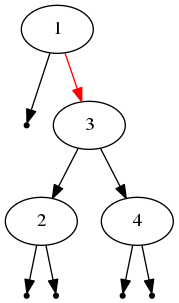

In [8]:
LLRBTrees.flipcolor!(arbol.root.right)
display(arbol)

## Inserción

Las tres operaciones anteriores se pueden utilizan en conjunto para mantener las invariantes deseadas. Las convenciones de inclinación a la izquierda, etc permiten que se reduzcan los casos a considerar.
En su artículo Sedgewick las presente en una gráfica muy concisa.

![2-3 vs BST](./casos_insertar.png)
***Fuente: Sedgewick, R. (2008, April). Left-leaning red-black trees. In Dagstuhl Workshop on Data Structures (p. 19).***

Siempre insertamos nodos rojos al llegar a una hoja, es por eso que el diagrama de arriba nos muestra como tratar los casos en que insertamos un nodo rojo como hijo o hermano de un nodo rojo.

Al final siempre terminamos pasando el vínculo al padre y la implementación recursiva se encarga de que volvamos a tomar esta misma decisión si tenemos dos nodos rojos.

Además, como las operaciones son balanceadas, se mantiene el balance del árbol.

## Perfilación

In [1]:
using DataStructures
using LLRBTrees
using ProfileView

elems = 100000

100000

In [48]:
dict = OrderedDict{Int,Int}()
@time for c in 1:elems
    dict[c] = rand(1:elems)
end

  0.045986 seconds (498.50 k allocations: 15.992 MB)


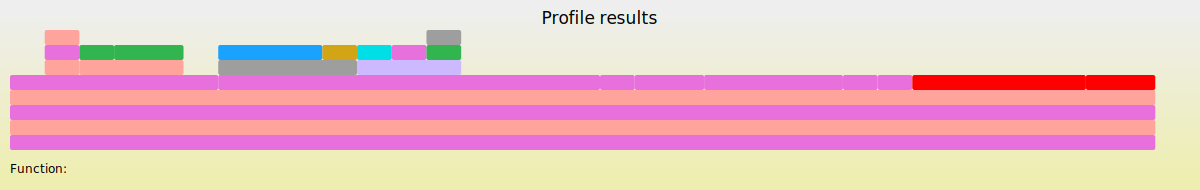

In [36]:
dict = OrderedDict{Int,Int}()
Profile.clear()
@profile for c in 1:elems
    dict[c] = rand(1:elems)
end
ProfileView.view()

In [2]:
arbol = LLRBTree{Int,Int}()
@time for c in 1:elems
    arbol[c] = rand(1:elems)
end

  0.406485 seconds (1.34 M allocations: 48.480 MB, 3.27% gc time)


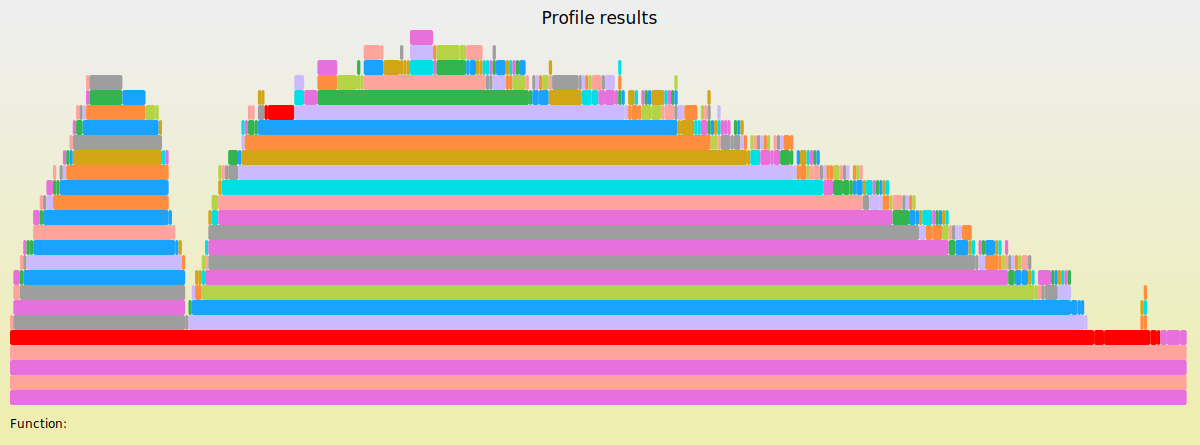

In [35]:
arbol = LLRBTree{Int,Int}()
Profile.clear()
@profile for c in 1:elems
    arbol[c] = rand(1:elems)
end
ProfileView.view()

In [4]:
@time for c in 1:elems
    (arbol[c])
end
    

  0.053425 seconds (402.81 k allocations: 9.287 MB)


In [5]:
@time for c in 1:elems
    (dict[c])
end

  0.041631 seconds (403.13 k allocations: 7.835 MB)


In [13]:
sizeof(arbol)

8

In [14]:
sizeof(dict)

40

In [51]:
whos(r"dict")

                          dict   2586 KB     DataStructures.OrderedDict{Int64,I…


In [50]:
whos(r"arbol")

                         arbol   8203 KB     LLRBTrees.LLRBTree{Int64,Int64}


In [3]:
@code_warntype delete!(arbol, 1)

Variables:
  tree::LLRBTrees.LLRBTree{Int64,Int64}
  key::Int64
  ##msg#7519::Tuple{ASCIIString}
  ##msg#7520::Tuple{ASCIIString}

Body:
  begin  # /home/ernesto/.julia/v0.4/LLRBTrees/src/LLRBTrees.jl, line 474:
      unless (LLRBTrees.isdefined)(tree::LLRBTrees.LLRBTree{Int64,Int64},:root)::Bool goto 2 # /home/ernesto/.julia/v0.4/LLRBTrees/src/LLRBTrees.jl, line 475:
      unless (Base.box)(Base.Bool,(Base.not_int)((top(getfield))((top(getfield))((top(getfield))(tree::LLRBTrees.LLRBTree{Int64,Int64},:root)::LLRBTrees.TreeNode{Int64,Int64},:key)::Nullable{Int64},:isnull)::Bool)) goto 0 # /home/ernesto/.julia/v0.4/LLRBTrees/src/LLRBTrees.jl, line 476:
      GenSym(1) = (LLRBTrees.delete_node)((top(getfield))(tree::LLRBTrees.LLRBTree{Int64,Int64},:root)::LLRBTrees.TreeNode{Int64,Int64},key::Int64)::LLRBTrees.TreeNode{Int64,Int64}
      (top(setfield!))(tree::LLRBTrees.LLRBTree{Int64,Int64},:root,GenSym(1))::LLRBTrees.TreeNode{Int64,Int64} # /home/ernesto/.julia/v0.4/LLRBTrees/src/LLRBTre